In [37]:
import pandas as pd
import io
import requests
url="https://raw.githubusercontent.com/santus444/temp/master/Placement_Data_Full_Class.csv"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data_cleaned = data


In [38]:
data_cleaned.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [39]:
data_cleaned.workex = data_cleaned.workex.map({'No':0, 'Yes':1})
data_cleaned.gender = data_cleaned.gender.map({"F":0, "M":1})
data_cleaned.ssc_b = data_cleaned.ssc_b.map({"Others":0, "Central":1})
data_cleaned.hsc_b = data_cleaned.hsc_b.map({'Others':0, 'Central':1})
data_cleaned.hsc_s = data_cleaned.hsc_s.map({'Commerce':0, 'Arts':1, 'Science':2})
data_cleaned.degree_t = data_cleaned.degree_t.map({'Others':0, 'Comm&Mgmt':1, 'Sci&Tech':2})
data_cleaned.specialisation = data_cleaned.specialisation.map({'Mkt&Fin':0, 'Mkt&HR':1})
data_cleaned.status = data_cleaned.status.map({'Not Placed':0, 'Placed':1})
data_cleaned.head()

data_no_na = data_cleaned.drop(labels='salary', axis=1) 
data_no_na = data_no_na.drop(labels='sl_no', axis=1) 
data_no_na.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,0,91.00,0,0,58.00,2,0,55.0,1,58.80,1
1,1,79.33,1,78.33,0,2,77.48,2,1,86.5,0,66.28,1
2,1,65.00,1,68.00,1,1,64.00,1,0,75.0,0,57.80,1
3,1,56.00,1,52.00,1,2,52.00,2,0,66.0,1,59.43,0
4,1,85.80,1,73.60,1,0,73.30,1,0,96.8,0,55.50,1


In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_no_na, data_no_na["status"]):
    strat_train_set = data_no_na.iloc[train_index]
    strat_test_set = data_no_na.iloc[test_index]

In [41]:
import time
def get_score(model, x_train, x_test, y_train, y_test ):
    start_time = time.time()
    model.fit(x_train, y_train)
    elapsed_time = time.time() - start_time
    print("Training time: ",elapsed_time)
    start_time = time.time()
    score = model.score(x_test, y_test)
    elapsed_time = time.time() - start_time
    print("Test time: ",elapsed_time)
    print("Score: ", score)

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# strat_train_set.describe()
from sklearn.model_selection import learning_curve

def calculate_learning_curve(train_sizes, data, classifier = DecisionTreeClassifier(max_depth=6, min_samples_split=10), n_jobs=-1):
    features = strat_train_set.columns[:-1]
    target = strat_train_set.columns[-1]
    return learning_curve(
    estimator = classifier,
    X = data[features],
#         X=data_no_na[features],
    y = data[target], 
#     y = data_no_na[target],       strat_train_set
        train_sizes = train_sizes, cv = 5,
    scoring = 'f1', n_jobs=n_jobs)#shuffle=True, random_state=40
    
train_sizes = [1, 10, 20, 40, 60, 80, 100, 137]#, 45136]
train_sizes, train_scores, validation_scores = calculate_learning_curve(train_sizes,strat_train_set, DecisionTreeClassifier(max_depth=3, min_samples_split=10))
   
#######
#######
import matplotlib.pyplot as plt
def plot_graphs(title, train_sizes, train_scores, validation_scores):
    train_scores_mean = (train_scores.mean(axis = 1))
    validation_scores_mean = (validation_scores.mean(axis = 1))
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training Score')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Score')
    plt.ylabel('Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(title, fontsize = 18, y = 1.03)
    plt.text(train_sizes[-1], train_scores_mean[-1]+0.01, train_scores_mean[-1])
    plt.text(train_sizes[-1], validation_scores_mean[-1]-0.02, validation_scores_mean[-1])
    plt.legend()
    ylim_max = 1 #np.nanmax(validation_scores_mean)
    ylim_min = 0 #np.nanmin(validation_scores_mean)
    plt.ylim(ylim_min, ylim_max)
    print("Training Score: ", train_scores_mean[-1]) 
    print("Cross validation Score: ", validation_scores_mean[-1])
    
def plot_learning_curve(train_sizes,strat_train_set, classifier=DecisionTreeClassifier(max_depth=3, min_samples_split=2), n_jobs=-1):
    train_sizes, train_scores, validation_scores = calculate_learning_curve(train_sizes,strat_train_set, classifier, n_jobs=n_jobs)
    plot_graphs('Learning curve holding out testing data', train_sizes, train_scores, validation_scores)  
    
#######
#######
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

def plot_validaiton_curve(data, classifier, param_name, param_range, n_jobs=-1):
    features = data.columns[:-1]
    target = data.columns[-1]
    X = data[features]
    y = data[target]
    train_scores, test_scores = validation_curve(
        classifier, X, y, param_name=param_name, param_range=param_range,
        scoring="f1", verbose=2, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    y_min = min(np.nanmin(train_scores_mean), np.nanmin(test_scores_mean))
    y_max = max(np.nanmax(test_scores_mean), np.nanmax(train_scores_mean))
    plt.ylim(y_min-0.2, y_max+0.2)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    
#     plt.text(train_sizes[2], train_scores_mean.min(), train_scores_mean[-1])
#     plt.text(train_sizes[2], test_scores_mean.min(), test_scores_mean[-1])
    plt.show()
    
    print("Training Score: ", train_scores_mean[-1]) 
    
    print("Cross validation Score: ", test_scores_mean[-1]) 

In [44]:
clf = GridSearchCV(DecisionTreeClassifier(), {
    'max_depth': [ 1, 2,3,4,  5, 6, 7],
    'min_samples_split':[ 2, 3, 5, 10, 20]
}, cv=5, return_train_score=False, n_jobs=-1, verbose=3, scoring="f1")
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
# clf.cv_results_
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.3s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002551,0.000076,0.002291,0.000364,1,2,"{'max_depth': 1, 'min_samples_split': 2}",0.840000,0.857143,0.901961,0.840000,0.862745,0.860370,0.022697,10
1,0.002659,0.000161,0.002264,0.000175,1,3,"{'max_depth': 1, 'min_samples_split': 3}",0.840000,0.857143,0.901961,0.840000,0.862745,0.860370,0.022697,10
2,0.003967,0.001101,0.003407,0.001074,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.840000,0.857143,0.901961,0.840000,0.862745,0.860370,0.022697,10
3,0.004764,0.000305,0.004144,0.000173,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.840000,0.857143,0.901961,0.840000,0.862745,0.860370,0.022697,10
4,0.004904,0.000278,0.004519,0.000108,1,20,"{'max_depth': 1, 'min_samples_split': 20}",0.840000,0.857143,0.901961,0.840000,0.862745,0.860370,0.022697,10
5,0.005046,0.000199,0.004336,0.000120,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.857143,0.700000,0.901961,0.790698,0.862745,0.822509,0.070925,30
6,0.004915,0.000356,0.003836,0.000405,2,3,"{'max_depth': 2, 'min_samples_split': 3}",0.857143,0.700000,0.901961,0.790698,0.862745,0.822509,0.070925,30
7,0.005148,0.001247,0.003726,0.000698,2,5,"{'max_depth': 2, 'min_samples_split': 5}",0.857143,0.700000,0.901961,0.790698,0.862745,0.822509,0.070925,30
8,0.004443,0.000155,0.003608,0.000058,2,10,"{'max_depth': 2, 'min_samples_split': 10}",0.857143,0.700000,0.901961,0.790698,0.862745,0.822509,0.070925,30
9,0.004518,0.000244,0.003681,0.000260,2,20,"{'max_depth': 2, 'min_samples_split': 20}",0.857143,0.700000,0.901961,0.790698,0.862745,0.822509,0.070925,30


Training Score:  0.9681875998751034
Cross validation Score:  0.8056152157021723


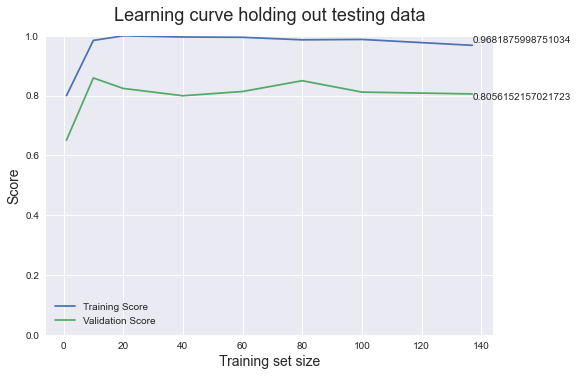

In [51]:
plot_learning_curve(train_sizes,strat_train_set, DecisionTreeClassifier(max_depth=5, min_samples_split=3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


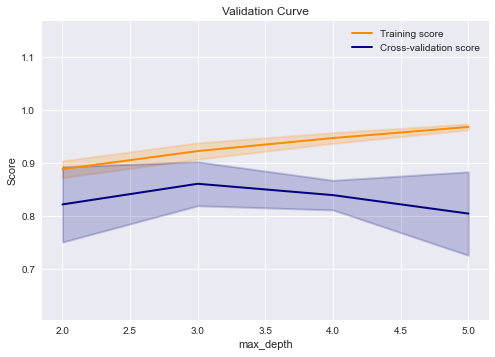

Training Score:  0.9683827484607
Cross validation Score:  0.8052527856793649


In [52]:
plot_validaiton_curve(strat_train_set, DecisionTreeClassifier(min_samples_split=3), "max_depth", [2,3,4, 5])

Training Score:  0.9225080123231383
Cross validation Score:  0.8613745695151801


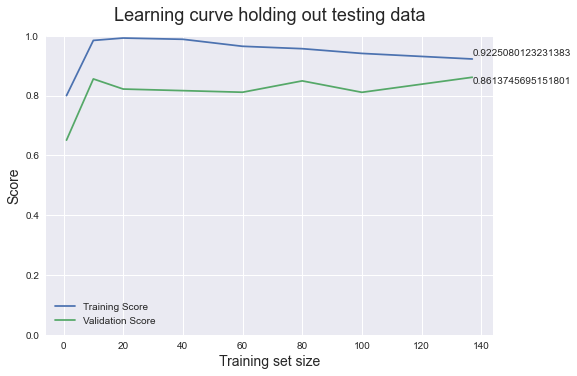

In [53]:
plot_learning_curve(train_sizes,strat_train_set, DecisionTreeClassifier(max_depth=3, min_samples_split=3))

In [54]:
tree_final = DecisionTreeClassifier(max_depth=3, min_samples_split=3)

get_score(tree_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])


Training time:  0.012964963912963867
Test time:  0.002671957015991211
Score:  0.6744186046511628


In [55]:
clf = GridSearchCV(MLPClassifier(), {
    'activation': ['logistic', 'sgd'],
    'solver':['adam'],
    'hidden_layer_sizes':[(100,), (200),(300), (300,400)], #did search for 100, 200, 400, 500, 600
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.001],
    'max_iter': [5000],
    'momentum': [0.1],
    'alpha':[0.00001], 
    'random_state':[42],
    'warm_start':[False]
}, cv=5, return_train_score=False, verbose=3, n_jobs=-1, scoring="f1")
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  40 | elapsed:    4.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    7.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.2s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_max_iter,...,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.464825,0.175587,0.006882,0.000300,logistic,1e-05,"(100,)",adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.863636,0.93617,0.884615,0.837209,0.830189,0.870364,0.038189,4
1,2.601952,0.343071,0.006042,0.001015,logistic,1e-05,200,adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.913043,0.87500,0.905660,0.883721,0.846154,0.884716,0.023764,2
2,2.775660,0.463477,0.005418,0.001353,logistic,1e-05,300,adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.888889,0.87500,0.901961,0.883721,0.867925,0.883499,0.011702,3
3,3.683862,0.590851,0.003693,0.000702,logistic,1e-05,"(300, 400)",adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.938776,0.87500,0.901961,0.863636,0.867925,0.889459,0.028029,1
4,0.002656,0.000414,0.000000,0.000000,sgd,1e-05,"(100,)",adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,0.002757,0.000141,0.000000,0.000000,sgd,1e-05,200,adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,0.002571,0.000290,0.000000,0.000000,sgd,1e-05,300,adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.002942,0.000410,0.000000,0.000000,sgd,1e-05,"(300, 400)",adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [56]:
clf = GridSearchCV(MLPClassifier(), {
    'activation': ['logistic', 'sgd'],
    'solver':['adam'],
    'hidden_layer_sizes':[(100,200), (200, 300),(300, 400), (300,500)], #did search for 100, 200, 400, 500, 600
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.001],
    'max_iter': [5000],
    'momentum': [0.1],
    'alpha':[0.00001], 
    'random_state':[42],
    'warm_start':[False]
}, cv=5, return_train_score=False, verbose=3, n_jobs=-1, scoring="f1")
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  40 | elapsed:    6.9s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:   13.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.8s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_max_iter,...,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.922805,0.515586,0.009573,0.000835,logistic,1e-05,"(100, 200)",adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.863636,0.851064,0.901961,0.857143,0.846154,0.863992,0.019870,3
1,8.791911,1.784314,0.011043,0.004436,logistic,1e-05,"(200, 300)",adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.809524,0.875000,0.901961,0.863636,0.867925,0.863609,0.030148,4
2,10.333866,0.513212,0.007039,0.001318,logistic,1e-05,"(300, 400)",adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.938776,0.875000,0.901961,0.863636,0.867925,0.889459,0.028029,1
3,8.947891,2.158202,0.003661,0.000798,logistic,1e-05,"(300, 500)",adaptive,0.001,5000,...,False,"{'activation': 'logistic', 'alpha': 1e-05, 'hi...",0.888889,0.875000,0.901961,0.863636,0.867925,0.879482,0.014132,2
4,0.003737,0.000248,0.000000,0.000000,sgd,1e-05,"(100, 200)",adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,0.002866,0.000575,0.000000,0.000000,sgd,1e-05,"(200, 300)",adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,0.004580,0.001918,0.000000,0.000000,sgd,1e-05,"(300, 400)",adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.004042,0.000994,0.000000,0.000000,sgd,1e-05,"(300, 500)",adaptive,0.001,5000,...,False,"{'activation': 'sgd', 'alpha': 1e-05, 'hidden_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


Training Score:  0.9894288913773795
Cross validation Score:  0.8726236661888835


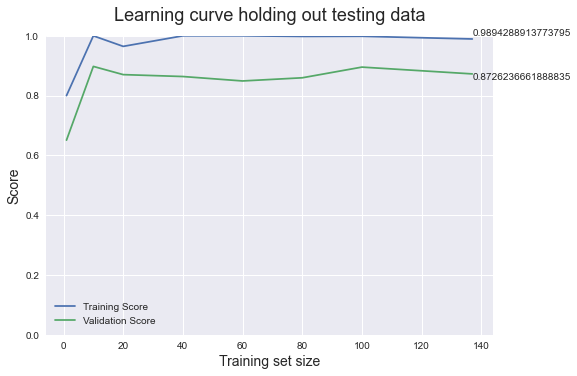

In [57]:
plot_learning_curve(train_sizes,strat_train_set, MLPClassifier(activation='logistic',solver='adam',learning_rate='adaptive',learning_rate_init= 0.0001,max_iter=5000,momentum=0.1, warm_start=False, hidden_layer_sizes=(300,400),alpha=0.00001))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   50.3s remaining:   50.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


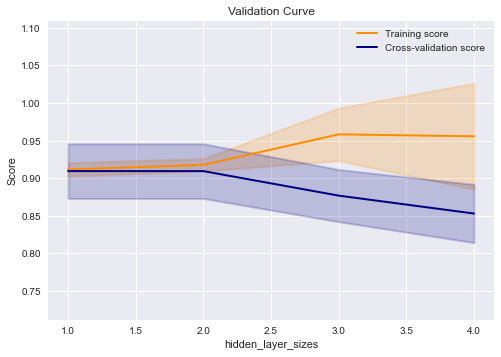

Training Score:  0.9557819276971637
Cross validation Score:  0.8530030203714414


In [58]:
    features = strat_train_set.columns[:-1]
    target = strat_train_set.columns[-1]
    X = strat_train_set[features]
    y = strat_train_set[target]
    train_scores, test_scores = validation_curve(
        MLPClassifier(activation='logistic',solver='adam',learning_rate='adaptive',learning_rate_init= 0.0001,max_iter=5000,momentum=0.1, warm_start=True, alpha=0.0000001)
        , X, y, param_name="hidden_layer_sizes", param_range=[(300,), (400,), (100,200), (300, 400)],
        scoring="f1", verbose=2, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel("hidden_layer_sizes")
    plt.ylabel("Score")
    plt.ylim(train_scores_mean.min()-0.2, test_scores_mean.max()+0.2)
    lw = 2
    plt.plot([1, 2, 3, 4], train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between([1, 2, 3, 4], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot([1, 2, 3, 4], test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between([1, 2, 3, 4], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    
#     plt.text(train_sizes[2], train_scores_mean.min(), train_scores_mean[-1])
#     plt.text(train_sizes[2], test_scores_mean.min(), test_scores_mean[-1])
    plt.show()
    
    print("Training Score: ", train_scores_mean[-1]) 
    
    print("Cross validation Score: ", test_scores_mean[-1]) 

Training Score:  0.915367022203122
Cross validation Score:  0.9182461506341667


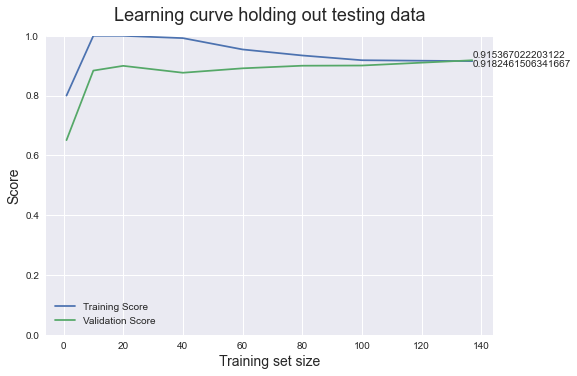

In [59]:
plot_learning_curve(train_sizes,strat_train_set, MLPClassifier(activation='logistic',solver='adam',learning_rate='adaptive',learning_rate_init= 0.0001,max_iter=5000,momentum=0.1, warm_start=False, hidden_layer_sizes=(300,),alpha=0.00001))

In [60]:
nn_final = MLPClassifier(activation='logistic',solver='adam',learning_rate='adaptive',learning_rate_init= 0.0001,max_iter=5000,momentum=0.1, warm_start=False, hidden_layer_sizes=(300,),alpha=0.00001)

get_score(nn_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])



Training time:  6.071747779846191
Test time:  0.014110088348388672
Score:  0.7906976744186046


In [61]:
clf = GridSearchCV(AdaBoostClassifier(), {
    'n_estimators': [  20, 50, 100], 
    'learning_rate' : [ 0.6, 0.7, 0.8],
    'algorithm': [ 'SAMME.R'],
    'random_state':[42]
}, cv=5, return_train_score=False, verbose=3, scoring='f1', n_jobs=-1)
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    5.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.133956,0.011014,0.022057,0.002604,SAMME.R,0.6,20,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.857143,0.765957,0.901961,0.869565,0.862745,0.851474,0.045494,5
1,0.280125,0.042102,0.045541,0.007147,SAMME.R,0.6,50,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.869565,0.765957,0.884615,0.893617,0.840000,0.850751,0.046138,6
2,0.414177,0.052237,0.049134,0.002741,SAMME.R,0.6,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.916667,0.765957,0.884615,0.893617,0.857143,0.863600,0.052411,2
3,0.092670,0.009005,0.019920,0.001402,SAMME.R,0.7,20,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.857143,0.765957,0.901961,0.844444,0.862745,0.846450,0.044597,7
4,0.212136,0.008774,0.030067,0.003719,SAMME.R,0.7,50,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.826087,0.765957,0.862745,0.869565,0.823529,0.829577,0.036866,9
5,0.388612,0.014509,0.048376,0.004323,SAMME.R,0.7,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,3
6,0.079965,0.004154,0.018419,0.009466,SAMME.R,0.8,20,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.8,...",0.833333,0.765957,0.901961,0.844444,0.840000,0.837139,0.043231,8
7,0.189129,0.014139,0.026055,0.001867,SAMME.R,0.8,50,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.8,...",0.851064,0.765957,0.884615,0.893617,0.875000,0.854051,0.046277,4
8,0.340958,0.037313,0.035521,0.005705,SAMME.R,0.8,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.8,...",0.913043,0.765957,0.884615,0.893617,0.875000,0.866447,0.051790,1


In [62]:
clf = GridSearchCV(AdaBoostClassifier(), {
    'n_estimators': [100, 150, 200, 300, 500], 
    'learning_rate' : [ 0.6, 0.7, 0.8],
    'algorithm': [ 'SAMME.R'],
    'random_state':[42]
}, cv=5, return_train_score=False, verbose=3, scoring='f1', n_jobs=-1)
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    5.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.9s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.486317,0.005915,0.054838,0.002541,SAMME.R,0.6,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.916667,0.765957,0.884615,0.893617,0.857143,0.863600,0.052411,6
1,0.687546,0.032496,0.085231,0.007755,SAMME.R,0.6,150,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.936170,0.765957,0.884615,0.893617,0.857143,0.867501,0.056761,2
2,0.878461,0.027210,0.090994,0.006631,SAMME.R,0.6,200,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,10
3,1.305849,0.044912,0.153898,0.005986,SAMME.R,0.6,300,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.888889,0.791667,0.884615,0.875000,0.840000,0.856034,0.036486,14
4,2.155546,0.060784,0.257038,0.006059,SAMME.R,0.6,500,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.888889,0.791667,0.901961,0.875000,0.840000,0.859503,0.039720,9
5,0.377254,0.038802,0.062391,0.007032,SAMME.R,0.7,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,10
6,0.675263,0.008771,0.088730,0.004803,SAMME.R,0.7,150,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,10
7,0.871189,0.041651,0.103467,0.003956,SAMME.R,0.7,200,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.901961,0.893617,0.840000,0.862916,0.054600,7
8,1.344052,0.024414,0.163995,0.005501,SAMME.R,0.7,300,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.888889,0.791667,0.901961,0.897959,0.840000,0.864095,0.042478,5
9,2.272997,0.022870,0.250338,0.014600,SAMME.R,0.7,500,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.869565,0.791667,0.901961,0.875000,0.857143,0.859067,0.036744,13


In [63]:
clf = GridSearchCV(AdaBoostClassifier(), {
    'n_estimators': [100, 150, 160, 170, 180], 
    'learning_rate' : [ 0.6, 0.7, 0.8],
    'algorithm': [ 'SAMME.R'],
    'random_state':[42]
}, cv=5, return_train_score=False, verbose=3, scoring='f1', n_jobs=-1)
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    3.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.7s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.453401,0.008681,0.057418,0.004039,SAMME.R,0.6,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.916667,0.765957,0.884615,0.893617,0.857143,0.863600,0.052411,9
1,0.643928,0.002471,0.093904,0.003714,SAMME.R,0.6,150,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.936170,0.765957,0.884615,0.893617,0.857143,0.867501,0.056761,2
2,0.697016,0.007255,0.077919,0.003321,SAMME.R,0.6,160,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.936170,0.765957,0.884615,0.893617,0.840000,0.864072,0.057791,7
3,0.689918,0.026844,0.090818,0.004864,SAMME.R,0.6,170,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.936170,0.765957,0.884615,0.893617,0.840000,0.864072,0.057791,7
4,0.733996,0.012848,0.090510,0.006985,SAMME.R,0.6,180,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.6,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,13
5,0.421729,0.018276,0.058512,0.005359,SAMME.R,0.7,100,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,13
6,0.639435,0.008641,0.080527,0.004570,SAMME.R,0.7,150,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.884615,0.893617,0.840000,0.859447,0.052521,13
7,0.635635,0.031456,0.080260,0.002217,SAMME.R,0.7,160,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.901961,0.893617,0.857143,0.866344,0.053582,6
8,0.694985,0.021276,0.086599,0.001287,SAMME.R,0.7,170,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.901961,0.893617,0.840000,0.862916,0.054600,10
9,0.715174,0.024647,0.092833,0.003351,SAMME.R,0.7,180,42,"{'algorithm': 'SAMME.R', 'learning_rate': 0.7,...",0.913043,0.765957,0.901961,0.893617,0.840000,0.862916,0.054600,10


Training Score:  1.0
Cross validation Score:  0.8465555555555555


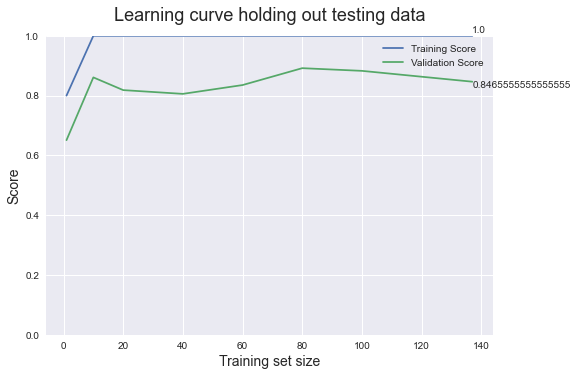

In [64]:
plot_learning_curve(train_sizes,strat_train_set, AdaBoostClassifier(n_estimators=150,learning_rate=0.8,random_state=42))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


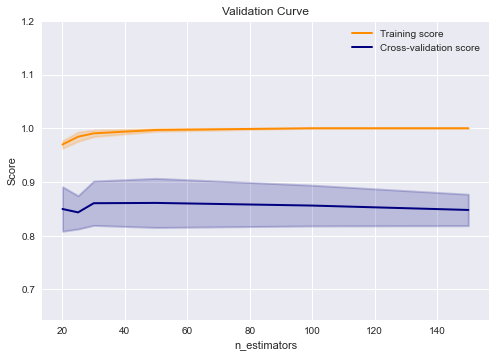

Training Score:  1.0
Cross validation Score:  0.8478794326241135


In [67]:
plot_validaiton_curve(strat_train_set, AdaBoostClassifier(learning_rate=0.8,random_state=42), "n_estimators", [20,25, 30, 50,100, 150])

Training Score:  0.9903966619821116
Cross validation Score:  0.860451914098973


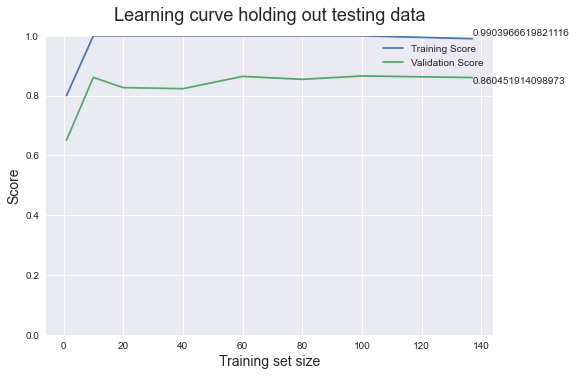

In [68]:
plot_learning_curve(train_sizes,strat_train_set, AdaBoostClassifier(n_estimators=30,learning_rate=0.8,random_state=42))

In [69]:
ada_final = AdaBoostClassifier(n_estimators=30,learning_rate=0.8,random_state=42)

get_score(ada_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])

Training time:  0.05540013313293457
Test time:  0.009696006774902344
Score:  0.8372093023255814


In [71]:
p = Pipeline([('scaler', Normalizer()),
('model', KNeighborsClassifier())])
hyperparams = {
'model__n_neighbors' : [ 7,8, 9, 10],
'model__n_jobs':[-1],
    'model__weights':["distance"],
    'model__p':[1,2]
 }

clf = GridSearchCV(p,hyperparams, cv=5, return_train_score=False, verbose=3, n_jobs=-1, scoring="f1")
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  40 | elapsed:    2.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_jobs,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009685,0.000682,0.022690,0.001024,-1,7,1,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 7,...",0.816327,0.821429,0.836364,0.784314,0.851852,0.822057,0.022584,8
1,0.010458,0.000324,0.021481,0.001073,-1,7,2,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 7,...",0.823529,0.821429,0.857143,0.823529,0.851852,0.835496,0.015623,3
2,0.009672,0.000415,0.027340,0.007511,-1,8,1,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 8,...",0.816327,0.807018,0.857143,0.784314,0.851852,0.823331,0.027547,7
3,0.014009,0.002590,0.028530,0.003285,-1,8,2,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 8,...",0.840000,0.800000,0.872727,0.800000,0.851852,0.832916,0.028847,4
4,0.012190,0.000765,0.027500,0.004689,-1,9,1,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 9,...",0.840000,0.807018,0.842105,0.784314,0.851852,0.825058,0.025367,6
5,0.011163,0.000240,0.021770,0.000565,-1,9,2,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 9,...",0.840000,0.821429,0.872727,0.823529,0.851852,0.841907,0.019024,1
6,0.010148,0.001278,0.016513,0.001742,-1,10,1,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 10...",0.840000,0.807018,0.857143,0.784314,0.851852,0.828065,0.027968,5
7,0.007863,0.000446,0.015087,0.000999,-1,10,2,distance,"{'model__n_jobs': -1, 'model__n_neighbors': 10...",0.840000,0.821429,0.872727,0.807692,0.851852,0.838740,0.022770,2


Training Score:  1.0
Cross validation Score:  0.8955767195767196


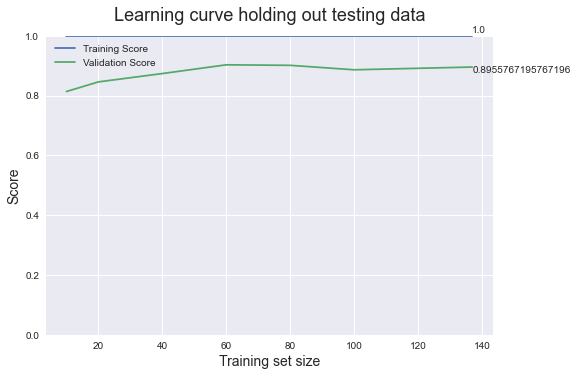

In [72]:
p = Pipeline([('scaler', Normalizer()),
('model', KNeighborsClassifier(n_neighbors=9, weights='distance', p=2, n_jobs=-1))])

plot_learning_curve(train_sizes[1:],strat_train_set, p)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished


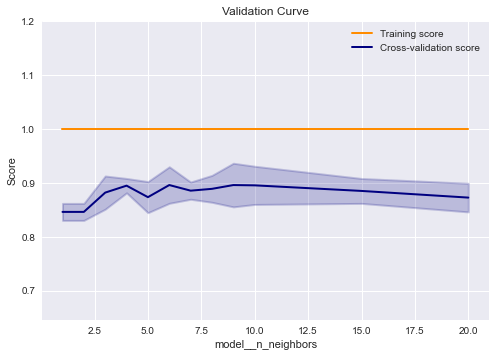

Training Score:  1.0
Cross validation Score:  0.8723364266760495


In [79]:
p = Pipeline([('scaler', Normalizer()),
('model', KNeighborsClassifier(weights='distance', p=2, n_jobs=-1))])
plot_validaiton_curve(strat_train_set, p, "model__n_neighbors", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], n_jobs=-1)

Training Score:  1.0
Cross validation Score:  0.8990588235294117


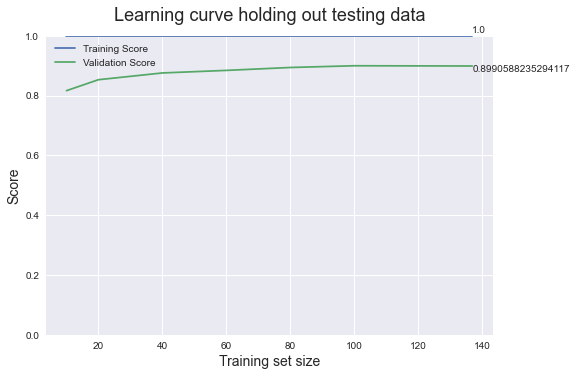

In [76]:
p = Pipeline([('scaler', Normalizer()),
('model', KNeighborsClassifier(n_neighbors=6, weights='distance', p=2, n_jobs=-1))])

plot_learning_curve(train_sizes[1:],strat_train_set, p)

In [89]:
knn_final = Pipeline([('scaler', Normalizer()),
('model', KNeighborsClassifier(n_neighbors=6, weights='distance', p=2, n_jobs=-1))])

get_score(knn_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])

Training time:  0.003906965255737305
Test time:  0.010251998901367188
Score:  0.627906976744186


In [82]:
p = Pipeline([('scaler', Normalizer()),
('model', SVC())])
hyperparams = {
'model__C':[20,40, 100],
'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
    'model__degree': [4, 5, 6, 7]
 }

clf = GridSearchCV(p,hyperparams, cv=5, return_train_score=False, verbose=3, n_jobs=-1, scoring="f1")
clf.fit(strat_train_set.iloc[:,:11],  strat_train_set.iloc[:,12])
df = pd.DataFrame(clf.cv_results_)
df

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__degree,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005210,0.000121,0.003049,0.000271,20,4,linear,"{'model__C': 20, 'model__degree': 4, 'model__k...",0.842105,0.793103,0.827586,0.821429,0.851852,0.827215,0.020129,37
1,0.005132,0.000455,0.002839,0.000468,20,4,poly,"{'model__C': 20, 'model__degree': 4, 'model__k...",0.862745,0.793103,0.872727,0.807692,0.884615,0.844177,0.036701,11
2,0.006955,0.000725,0.004316,0.000226,20,4,rbf,"{'model__C': 20, 'model__degree': 4, 'model__k...",0.872727,0.793103,0.857143,0.800000,0.851852,0.834965,0.032181,21
3,0.007657,0.000209,0.004148,0.000310,20,4,sigmoid,"{'model__C': 20, 'model__degree': 4, 'model__k...",0.813559,0.813559,0.827586,0.807018,0.807018,0.813748,0.007512,45
4,0.006595,0.000137,0.000000,0.000000,20,4,precomputed,"{'model__C': 20, 'model__degree': 4, 'model__k...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,58
5,0.007688,0.000129,0.004367,0.000313,20,5,linear,"{'model__C': 20, 'model__degree': 5, 'model__k...",0.842105,0.793103,0.827586,0.821429,0.851852,0.827215,0.020129,37
6,0.008122,0.000410,0.004214,0.000160,20,5,poly,"{'model__C': 20, 'model__degree': 5, 'model__k...",0.862745,0.807018,0.872727,0.823529,0.884615,0.850127,0.029750,8
7,0.008711,0.000639,0.005381,0.001313,20,5,rbf,"{'model__C': 20, 'model__degree': 5, 'model__k...",0.872727,0.793103,0.857143,0.800000,0.851852,0.834965,0.032181,21
8,0.008107,0.000597,0.005174,0.000632,20,5,sigmoid,"{'model__C': 20, 'model__degree': 5, 'model__k...",0.813559,0.813559,0.827586,0.807018,0.807018,0.813748,0.007512,45
9,0.006539,0.000394,0.000000,0.000000,20,5,precomputed,"{'model__C': 20, 'model__degree': 5, 'model__k...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,57


Training Score:  0.9339125144800097
Cross validation Score:  0.8924231046383737


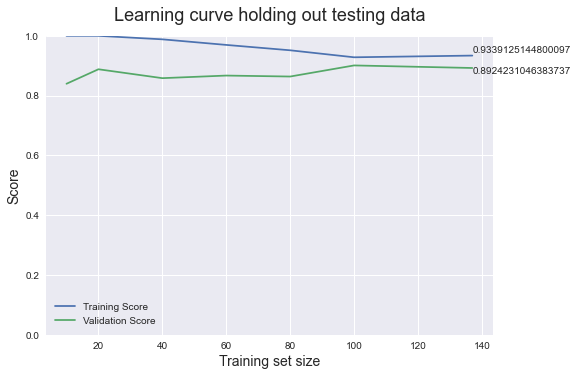

In [83]:
p = Pipeline([('scaler', Normalizer()),
('model', SVC(C=40, kernel='poly', degree=6))])

plot_learning_curve(train_sizes,strat_train_set, p)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


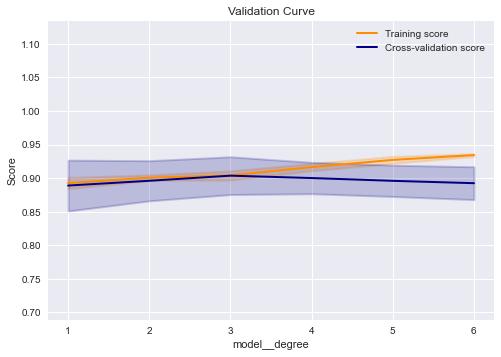

Training Score:  0.9343194407362301
Cross validation Score:  0.8924231046383737


In [85]:
p = Pipeline([('scaler', Normalizer()),
('model', SVC(C=40, kernel='poly'))])
plot_validaiton_curve(strat_train_set, p, "model__degree", [1, 2, 3, 4, 5, 6], n_jobs=-1)

Training Score:  0.9033811525485034
Cross validation Score:  0.9036281179138321


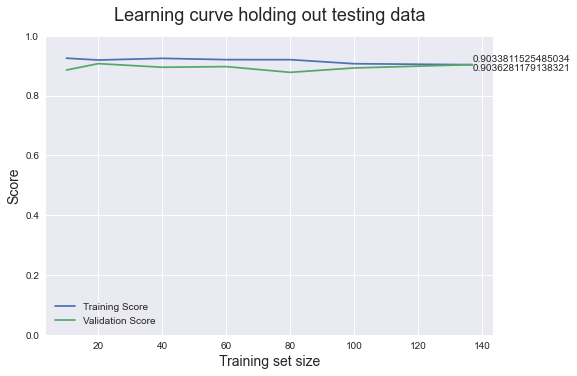

In [86]:
p = Pipeline([('scaler', Normalizer()),
('model', SVC(C=40, kernel='poly', degree=3))])

plot_learning_curve(train_sizes,strat_train_set, p)

Training Score:  0.8991108844409144
Cross validation Score:  0.8933673469387756


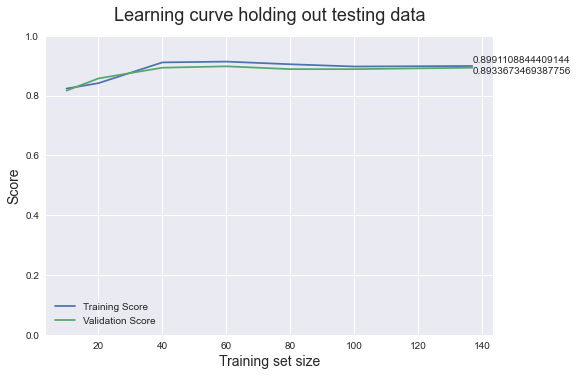

In [92]:
p = Pipeline([('scaler', Normalizer()),
('model', SVC(C=40, kernel='linear'))])

plot_learning_curve(train_sizes,strat_train_set, p)

Training Score:  0.9017262793509708
Cross validation Score:  0.8965686274509803


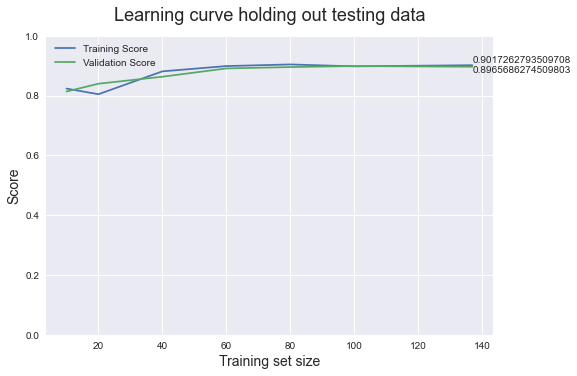

In [95]:
p = Pipeline([('scaler', Normalizer()),
('model', SVC(C=20, kernel='linear'))])

plot_learning_curve(train_sizes,strat_train_set, p)

In [88]:
svc_final = Pipeline([('scaler', Normalizer()),
('model', SVC(C=40, kernel='poly', degree=3))])

get_score(svc_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])

Training time:  0.004816770553588867
Test time:  0.002257108688354492
Score:  0.7906976744186046


In [96]:
svc_final = Pipeline([('scaler', Normalizer()),
('model', SVC(C=40, kernel='linear'))])

get_score(svc_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])

Training time:  0.012234926223754883
Test time:  0.005023956298828125
Score:  0.7674418604651163


In [ ]:
knn_final = Pipeline([('scaler', Normalizer()),
('model', KNeighborsClassifier(n_neighbors=6, weights='distance', p=2, n_jobs=-1))])

get_score(knn_final, strat_train_set.iloc[:,:11], strat_test_set.iloc[:,:11], strat_train_set.iloc[:,12], strat_test_set.iloc[:,12])